# Imports

In [1]:
from glob import glob
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline
# %load_ext line_profiler

# Calibrate the camera

In [2]:
CALIBRATION_IMAGES = "camera_cal/*.jpg"
CALIBRATION_IMAGE_COLS = 9
CALIBRATION_IMAGE_ROWS = 6

In [3]:
objpoints = [] # 3d points in real world space, can be logical from model
imgpoints = [] # 2d points on image plane, from photo


# Fill the logical points locations. shape = (54,3), 3rd column stays zero
objp = np.zeros(((CALIBRATION_IMAGE_COLS*CALIBRATION_IMAGE_ROWS),3), np.float32) # shape: (54, 3)
objp[:,:2] = np.mgrid[0:CALIBRATION_IMAGE_COLS,0:CALIBRATION_IMAGE_ROWS].T.reshape(-1,2) # Fills the first two columns of objp with a (54,2) combination of indexes 

def findChessboardCorners(fname):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_shape = gray.shape[::-1] # shape is the way to get the image size

    # Detect and register points
    ret, corners = cv2.findChessboardCorners(gray, (CALIBRATION_IMAGE_COLS, CALIBRATION_IMAGE_ROWS), None)
    return ret, corners, img_shape

# Load, preprocess and find corners for all images
images = glob(CALIBRATION_IMAGES)
img_shape = None
for fname in images:
    ret, corners, img_shape = findChessboardCorners(fname)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Compute coefficients (TODO: Is the img_shape for the original images, or for target images?)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)  

# Create undistort function
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


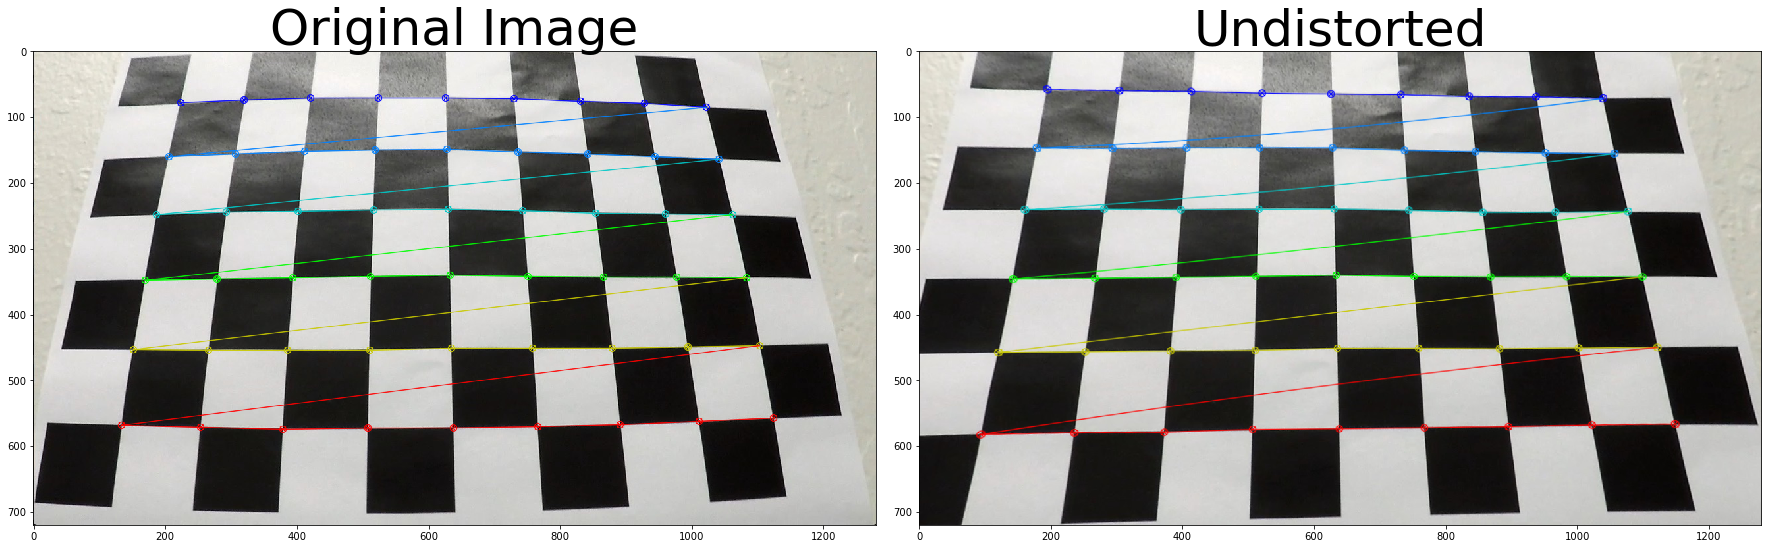

In [4]:
# Visualize 
vis_img_fname = images[13]
ret, corners, _ = findChessboardCorners(vis_img_fname)

if not ret:
    raise Exception('Could not detect corners in ' + vis_img_fname)
img = mpimg.imread(vis_img_fname)
img = cv2.drawChessboardCorners(img, (CALIBRATION_IMAGE_COLS, CALIBRATION_IMAGE_ROWS), corners, ret)
dst= undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Process input image

## Plannd pipeline:
1. Correct distortion
2. Color, gradient, threshold for lane pixels
3. Perspective transform
4. Find lane pixels, fit a lane boundary
5. Determine lane curvature 
6. Determine position with relation to center
6. Warp back to original image

## Remaining TODO:
1. Curvature measurement
2. Adjust parameters
3. Process video
  1. Load frames from video
  2. Render on original
  3. Print curvatureposition
  4. Save video
  5. ? Optimized search ? Smoothing ?

# Configuration for perspective transform

In [5]:
VIDEO_HEIGHT = 720
VIDEO_WIDTH = 1280
TRAPEZE_TOP_MARGIN = 572
TRAPEZE_BOTTOM_MARGIN = 0
TRAPEZE_TOP = 450
PAD=0

# Calculate trapezoid and matrices for perspective transform

In [6]:
# Source points - Trapezoid
top_left = (TRAPEZE_TOP_MARGIN, TRAPEZE_TOP)
top_right = (VIDEO_WIDTH - TRAPEZE_TOP_MARGIN, TRAPEZE_TOP)
low_left = (TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT)
low_right = (VIDEO_WIDTH - TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT)
src = np.float32([top_left, top_right, low_right, low_left])

width = VIDEO_WIDTH-PAD
height = VIDEO_HEIGHT-PAD
dst = np.float32([[PAD,PAD],[width,PAD],[width,height],[PAD,height]])

m = cv2.getPerspectiveTransform(src, dst)
m_inverse = cv2.getPerspectiveTransform(dst, src)

def perspectiveToTop(img):
    return cv2.warpPerspective(img, m, (VIDEO_WIDTH, VIDEO_HEIGHT), flags=cv2.INTER_LINEAR)

def topToPerspective(img):
    return cv2.warpPerspective(img, m_inverse, (VIDEO_WIDTH, VIDEO_HEIGHT), flags=cv2.INTER_LINEAR)


# Visualize on sample images

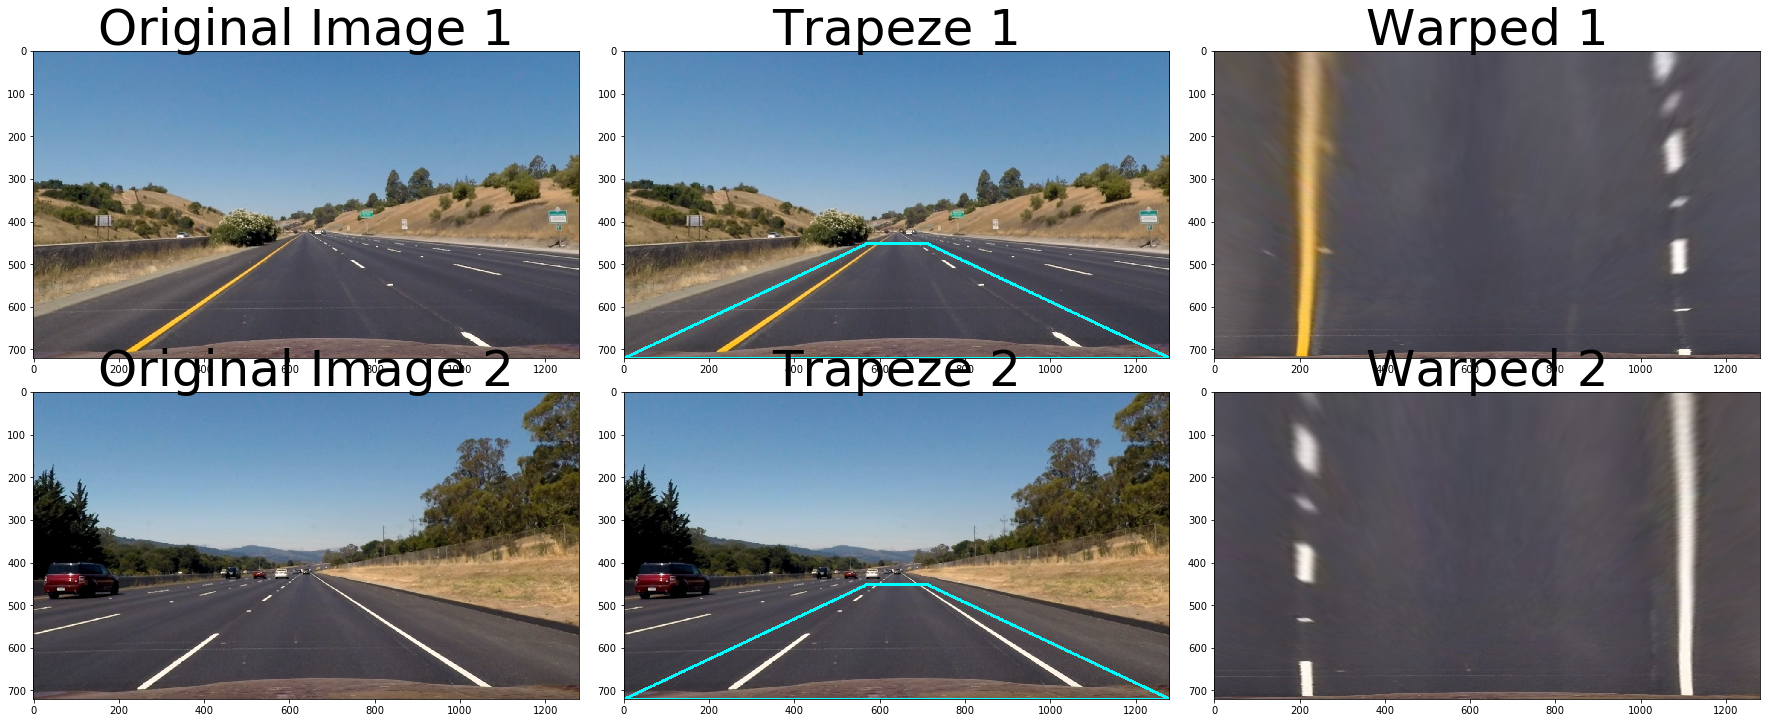

In [7]:

# Draw the trapeze for sample images
straight_lines_img1 = plt.imread('test_images/straight_lines1.jpg')
straight_lines_img2 = plt.imread('test_images/straight_lines2.jpg')

straight_lines_img1 = undistort(straight_lines_img1)
straight_lines_img2 = undistort(straight_lines_img2)

pts = np.array([[top_left,top_right,low_right, low_left]], np.int32)
pts = pts.reshape((-1,1,2))
straight_lines_img1_with_trapeze = np.copy(straight_lines_img1)
cv2.polylines(straight_lines_img1_with_trapeze,[pts],True,(0,255,255), thickness=5)
straight_lines_img2_with_trapeze = np.copy(straight_lines_img2)
cv2.polylines(straight_lines_img2_with_trapeze,[pts],True,(0,255,255), thickness=5)

# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
straight_lines_img1_from_top = perspectiveToTop(straight_lines_img1)
straight_lines_img2_from_top = perspectiveToTop(straight_lines_img2)


f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(straight_lines_img1)
ax1.set_title('Original Image 1', fontsize=50)
ax2.imshow(straight_lines_img1_with_trapeze)
ax2.set_title('Trapeze 1', fontsize=50)
ax3.imshow(straight_lines_img1_from_top)
ax3.set_title('Warped 1', fontsize=50)

ax4.imshow(straight_lines_img2)
ax4.set_title('Original Image 2', fontsize=50)
ax5.imshow(straight_lines_img2_with_trapeze)
ax5.set_title('Trapeze 2', fontsize=50)
ax6.imshow(straight_lines_img2_from_top)
ax6.set_title('Warped 2', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)


# Extract features, threshold and combine

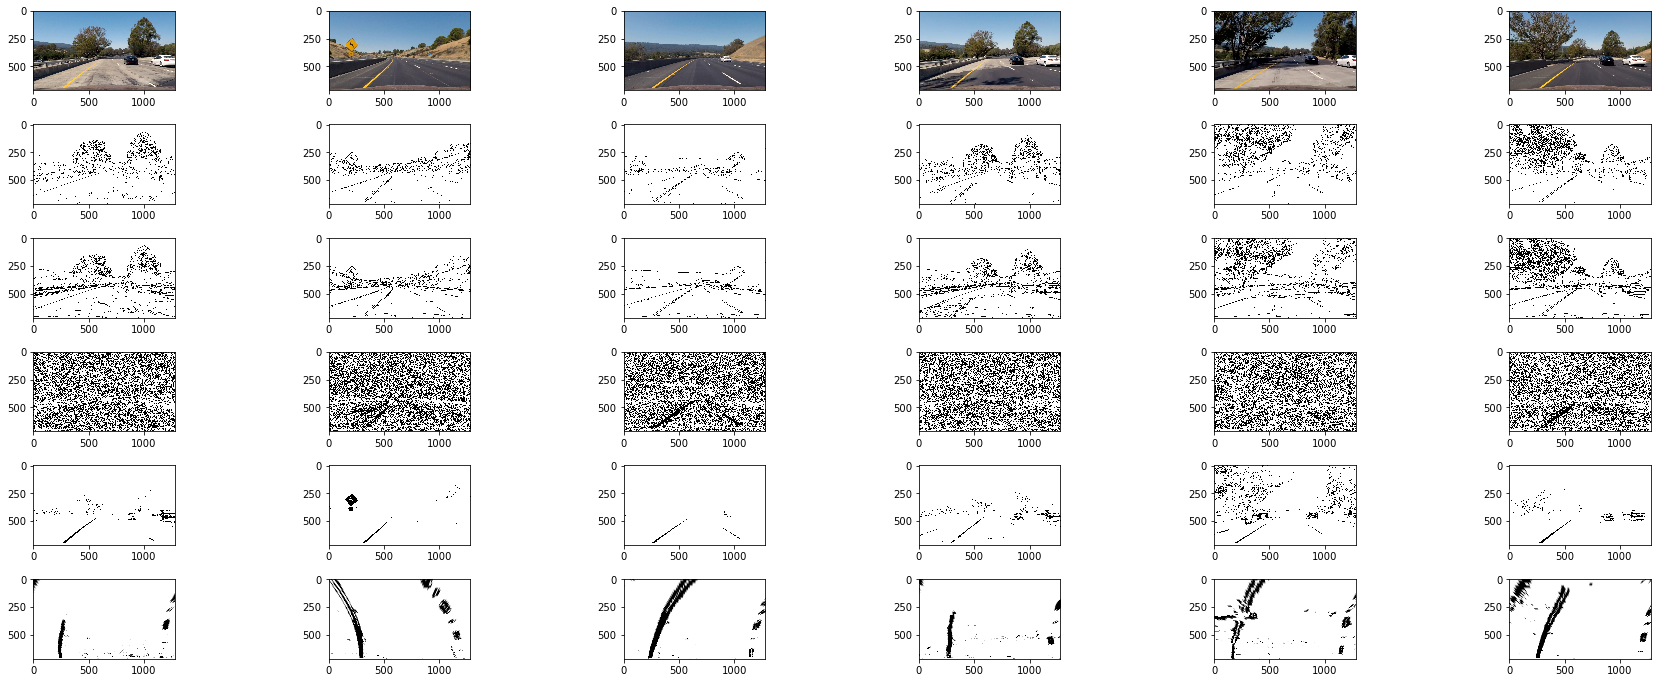

In [8]:
# Attribution: Function from lesson 21 in the project
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(grayscale_img, orient='x', thresh_min=0, thresh_max=255):

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(grayscale_img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobel = np.sqrt(sobel_x**2+sobel_y**2)
    
    # 2) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(grayscale_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_chan = hls[:,:,2]
    binary_output = np.zeros_like(s_chan)
    binary_output[(s_chan > thresh[0]) & (s_chan <= thresh[1])]=1
    # 3) Return a binary image of threshold result
    return binary_output
    
def combine_thresholds(test_img):
    test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    test_img_grad_x = abs_sobel_thresh(test_img_gray, orient='x', thresh_min=20, thresh_max=100)
    test_img_grad_mag = mag_thresh(test_img_gray, sobel_kernel=3, mag_thresh=(30,200))
    test_img_grad_dir = dir_threshold(test_img_gray, sobel_kernel=15, thresh=(0.7, 1.3))
    test_img_h_chan = hls_select(test_img, thresh=(170, 255))

    
    combined = np.zeros_like(test_img_grad_dir)
    combined[
        ((test_img_grad_x == 1) & (test_img_grad_x == 1)) | 
        ((test_img_grad_mag == 1) & (test_img_grad_dir == 1)) |
        (test_img_h_chan == 1)
    ] = 1
    
    return (combined, test_img_grad_x, test_img_grad_mag, test_img_grad_dir, test_img_h_chan)
    

# Show on test images
f, axes = plt.subplots(6, 6, figsize=(24, 9))
f.tight_layout()
test_fnames = glob('test_images/test*.jpg')
for idx, fname in enumerate(test_fnames[0:6]):
    test_img = plt.imread(fname)
    test_img = undistort(test_img)
    (combined, test_img_grad_x, test_img_grad_mag, test_img_grad_dir, test_img_h_chan) = combine_thresholds(test_img)
    combined_from_top = perspectiveToTop(combined)
    
#     test_img_from_top = perspectiveToTop(test_img)
    axes[0, idx].imshow(test_img, cmap='Greys')
    axes[1, idx].imshow(test_img_grad_x, cmap='Greys')
    axes[2, idx].imshow(test_img_grad_mag, cmap='Greys')
    axes[3, idx].imshow(test_img_grad_dir, cmap='Greys')
    axes[4, idx].imshow(test_img_h_chan, cmap='Greys')
    axes[5, idx].imshow(combined, cmap='Greys')
    axes[5, idx].imshow(combined_from_top, cmap='Greys')


plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)

# Exercise code to find peaks and pixels which belong to the lanes

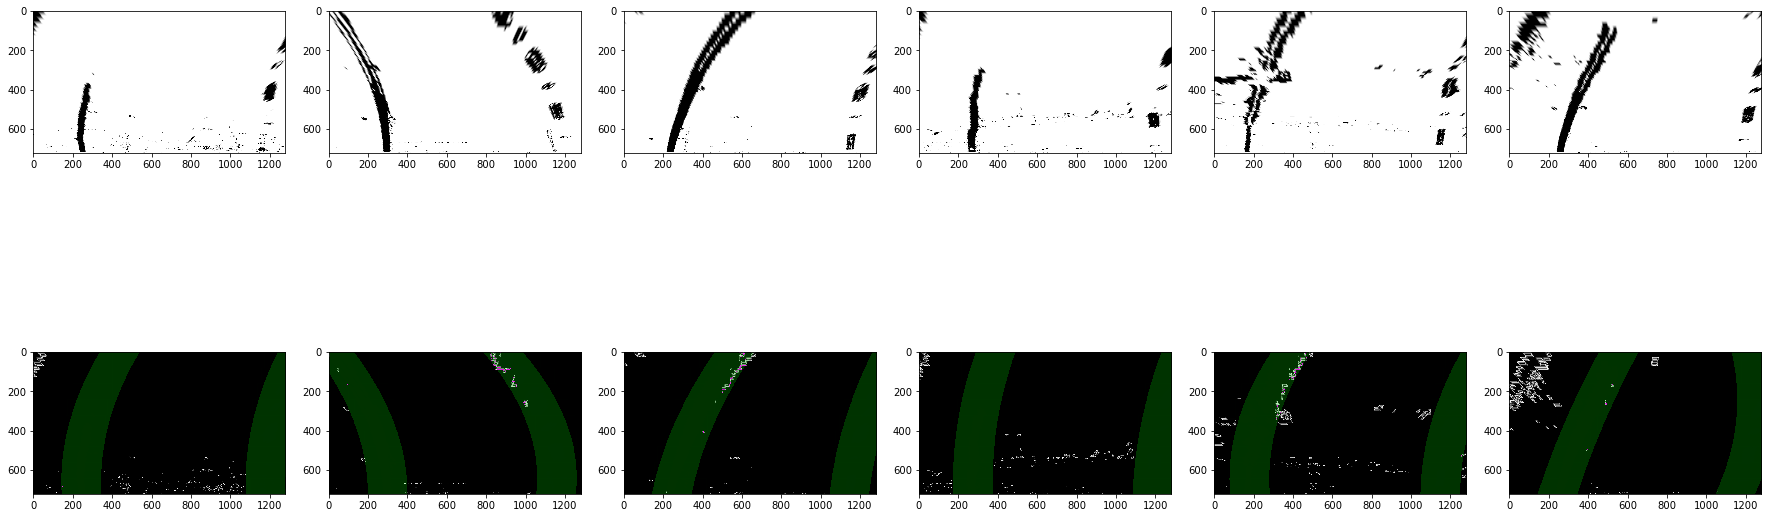

In [9]:
def find_starting_position_unhinted(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)

def search_lane_pixels(binary_warped, leftx_base, rightx_base, out_img):
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return (left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

def fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)


def plot_with_polynomial(binary_warped, left_fit, right_fit, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    
    # Set the width of the windows +/- margin
    margin = 100

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result
    
    
    
# Show on test images
f, axes = plt.subplots(2, 6, figsize=(24, 9))
f.tight_layout()
test_fnames = glob('test_images/test*.jpg')
for idx, fname in enumerate(test_fnames[0:6]):
    test_img = plt.imread(fname)
    test_img = undistort(test_img)
    (combined, _, _, _, _) = combine_thresholds(test_img)
    combined_from_top = perspectiveToTop(combined)
    
    # Create an output image (color) to draw on and visualize the result
    out_img = np.dstack((combined_from_top, combined_from_top, combined_from_top))*255
    
    (leftx_base, rightx_base) = find_starting_position_unhinted(combined_from_top)
    (left_lane_inds, right_lane_inds, nonzerox, nonzeroy) = search_lane_pixels(combined_from_top, leftx_base, rightx_base, out_img)
    (left_fit, right_fit) = fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
    
    out_img = plot_with_polynomial(combined_from_top, left_fit, right_fit, out_img)
    
    axes[0, idx].imshow(combined_from_top, cmap='Greys')
    axes[1, idx].imshow(out_img)


plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)

# Modified code to measure curvature (CHANGE to use actual lanes)

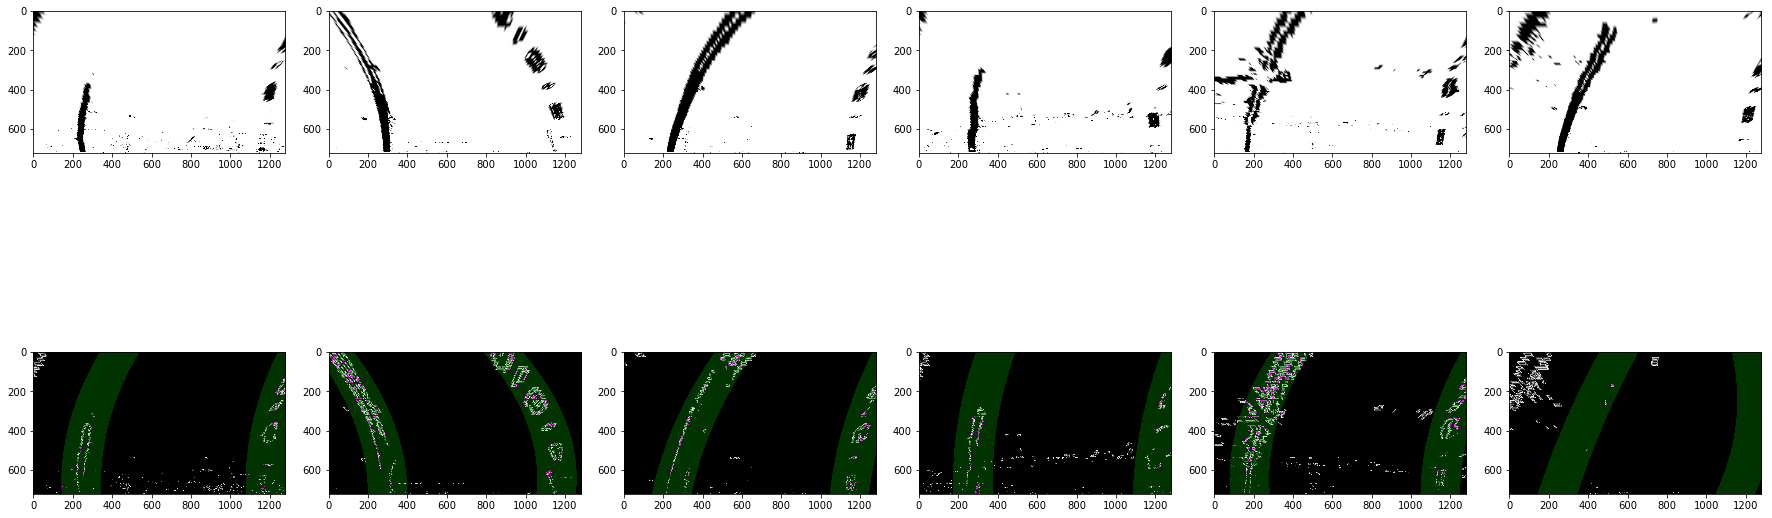

In [10]:

# def calculate_curvature(left_line_pts, right_line_pts, left_fit, right_fit):
def calculate_curvature(left_fit, 
                        right_fit, 
                        leftx,
                        lefty,
                        rightx,
                        righty):



    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
    y_eval = VIDEO_HEIGHT
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print("Pixel redius left: {} right: {} - distance: {}".format(
#         left_curverad, 
#         right_curverad, 
#         abs(left_curverad - right_curverad)))
    
    # Example values: 1926.74 1908.48
    
    # TODO: ploty can be: ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)
#     # Now our radius of curvature is in meters
#     print("World redius left: {} right: {} - distance: {}".format(
#         left_curverad, 
#         right_curverad, 
#         abs(left_curverad - right_curverad)))
          
#     print("======================================================")
    # Example values: 632.1 m    626.2 m

def visualize_curvature_measurements():
    # Show on test images
    f, axes = plt.subplots(2, 6, figsize=(24, 9))
    f.tight_layout()
    test_fnames = glob('test_images/test*.jpg')
    for idx, fname in enumerate(test_fnames[0:6]):
        test_img = plt.imread(fname)
        test_img = undistort(test_img)
        (combined, _, _, _, _) = combine_thresholds(test_img)
        combined_from_top = perspectiveToTop(combined)

        # Create an output image (color) to draw on and visualize the result
        out_img = np.dstack((combined_from_top, combined_from_top, combined_from_top))*255

        (leftx_base, rightx_base) = find_starting_position_unhinted(combined_from_top)
        (left_lane_inds, right_lane_inds, nonzerox, nonzeroy) = search_lane_pixels(combined_from_top, leftx_base, rightx_base, out_img)
        (left_fit, right_fit) = fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

        left_x = nonzerox[left_lane_inds] 
        left_y = nonzeroy[left_lane_inds] 

        right_x = nonzerox[right_lane_inds] 
        right_y = nonzeroy[right_lane_inds] 

        (left_curverad, right_curverad) = calculate_curvature(left_fit,
                            right_fit,
                            left_x,
                            left_y,
                            right_x,
                            right_y)

        
        out_img = plot_with_polynomial(combined_from_top, left_fit, right_fit, out_img)

        axes[0, idx].imshow(combined_from_top, cmap='Greys')
        axes[1, idx].imshow(out_img)


    plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)

visualize_curvature_measurements()

# Process the video

In [12]:

PROJECT_VIDEO_INPUT_PATH = 'project_video.mp4'
PROJECT_VIDEO_OUTPUT_PATH = 'output_images/project_video_output.mov'
PROJECT_CH_VIDEO_INPUT_PATH = 'challenge_video.mp4'
PROJECT_CH_VIDEO_OUTPUT_PATH = 'output_images/challenge_video.mov'
PROJECT_HCH_VIDEO_INPUT_PATH = 'harder_challenge_video.mp4'
PROJECT_HCH_VIDEO_OUTPUT_PATH = 'output_images/harder_challenge_video.mov'


class State:
    def __init__(self, frame_size):
        self.frame_idx = 0
        self.frame_size = frame_size
        self.lane_tracker = LanePolylineTracker([0.1,0.2,0.3,0.4])
        
class PerformanceTracker:
    def __init__(self):
        self.frame_processing_times = []

    def append_processing_time(self, time_span):
        self.frame_processing_times.append(time_span)
        
    def print_stats(self):
        # Print statistics
        if len(self.frame_processing_times) == 0:
            return
        total_processing_time = sum(self.frame_processing_times)
        avg_processing_time = total_processing_time / len(self.frame_processing_times)
        max_processing_time = max(self.frame_processing_times)
        print('Processing times: total - {}   average - {}   max - {} '.format( 
              total_processing_time,
              avg_processing_time,
              max_processing_time
             ))
        
class LanePolyline:
    def __init__(self, intercept, curvature):
        self.intercept = intercept
        self.curvature = curvature
        
class LanyPolylineAverager:
    def average(lane_polylines, weights):
        assert len(lane_polylines) == len(weights), "Number of polylines and number of weights must match"
        assert sum(weight) == 1, "Weights must sum to 1, and be ascending"
        intercept = 0
        curvature = 0
        for lp, idx in enumarate(lane_polylines):
            intercept = intercept + (lp.intercept * weights[idx])
            curvature = curvature + (lp.curvature * weights[idx])
        return LanePolyline(intercept, curvature)

class LanePolylineTracker:
    def __init__(self, weights):
        assert len(weights) > 0, "Must provide weights array"
        assert sum(weight) == 1, "Weights must sum to 1, and be ascending"
        self.detections = []
        self.weights = weights
        self.guesses_since_last_detection = 0
    
    def append_detection(self, lane_polyline):
        self.guesses_since_last_detection = 0
        self.detections.append(lane_polyline)
        
    def report_no_detection(self):
        self.guesses_since_last_detection += 1
        
    def get_weighted_average(self):
        num_to_eval = min(len(self.detections), len(self.weights))
        multiplier = 1
        if num_to_eval < len(self.weights):
            multiplier = 1/sum(self.weights[:-num_to_eval])
        weights = self.weights * multiplier
        lanes_to_eval = self.detections[:-num_to_eval]

class FrameAnnotator:
    def plot_curvature_and_distance(frame, 
                                    left_curve_rad, 
                                    right_curve_rad, 
                                    distance_from_center_m):
        font = cv2.FONT_HERSHEY_SIMPLEX
        color = (255, 255, 255)
        cv2.putText(frame, 
                   "Left Curvature: {0:.2f} m".format(left_curve_rad), 
                   (500, 50), font, 0.8, color, 2, cv2.LINE_AA)
        cv2.putText(frame, 
                   "Right Curvature: {0:.2f} m".format(right_curve_rad), 
                   (500, 100), font, 0.8, color, 2, cv2.LINE_AA)
        cv2.putText(frame, 
                   "Average Curvature: {0:.2f} m".format((left_curve_rad+right_curve_rad)/2), 
                   (500, 150), font, 0.8, color, 2, cv2.LINE_AA)
        cv2.putText(frame, 
                   "Distance from Lane Center: {0:.2f} m".format(distance_from_center_m), 
                   (500, 200), font, 0.8, color, 2, cv2.LINE_AA) 
        return frame
        
    def plot_lane_area(frame, 
                       left_line, 
                       right_line): 
        lane_boundary_color = (0, 0, 255)
        lane_area_color = (0, 255, 0)
        both_lines = np.concatenate((left_line, np.flipud(right_line)), axis=0)
        cv2.fillPoly(frame, [both_lines.astype(np.int32)], lane_area_color)
        cv2.polylines(frame, [left_line.astype(np.int32)], False, lane_boundary_color, thickness=6)
        cv2.polylines(frame, [right_line.astype(np.int32)], False, lane_boundary_color, thickness=6)
        return frame
        

def process_frame(frame, state):
    # Undistort
    #undistorted = undistort(frame)
    undistorted = frame
    print("WARNING: UNDISTORT DISABLED FOR SPEED!!!")

    # Threshold
    (combined, _, _, _, _) = combine_thresholds(frame)
    # Perspective to top
    combined_from_top = perspectiveToTop(combined)

    # Find lane start
    # TODO: Use hinted approach if unhinted gives outlier results
    (leftx_base, rightx_base) = find_starting_position_unhinted(combined_from_top)
    # Isolate lane pixels
    (left_lane_inds, right_lane_inds, nonzerox, nonzeroy) = search_lane_pixels(combined_from_top, leftx_base, rightx_base, out_img)
    # Fit a polynomial in pixel space
    (left_fit, right_fit) = fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
    
    # TODO:
    # 1. Smoothing of base finding (hinting) - search peak in distance from single detection or search near previous
    # 2. Smoothing of the polyline lane_tracker.append_detection(LanePolyline(base, curvature))
    # For polyline smoothing, we need to consider that deg=2 so we need to store 3 values, so polyline and polyline averager need to adapt
    # We also then need to handle the nonzerox[left_lane_inds] and nonzeroy[right_lane_inds] for averaging curvature...
    # I guess we can average just results using same weights?
    
    
    # Calculate curvature in world space
    left_x = nonzerox[left_lane_inds] 
    left_y = nonzeroy[left_lane_inds] 
    right_x = nonzerox[right_lane_inds] 
    right_y = nonzeroy[right_lane_inds] 
    (left_curve_rad, right_curve_rad) = calculate_curvature(left_fit,
                        right_fit,
                        left_x,
                        left_y,
                        right_x,
                        right_y)

    # Calculate vehicle position in lane
    # Vehicle position is in center of image. Lane position is in between lane bases. 
    # Distance is in pixels, so we must convert to meters
    lane_center = (rightx_base + leftx_base)/2
    image_center = state.frame_size[0]/2
    distance_from_center_px = image_center - lane_center
    distance_from_center_m = distance_from_center_px * 3.7/700 # meters per pixel in x dimension
    
    # Create an overlay image
    # This image is in pixel space and is composed of:
    # 1. Polynomials, drawn 
    # 2. A filled shape bounded by the polynomials, and top and buttom image edges
    overlay = np.zeros_like(frame)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, overlay.shape[0]-1, overlay.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    # TODO: Is zipping more efficient?
    left_line = np.array([left_fitx, ploty], dtype=np.int32).T
    right_line = np.array([right_fitx, ploty], dtype=np.int32).T
    
    FrameAnnotator.plot_lane_area(overlay, 
                                  left_line, 
                                  right_line)
        
    # Perspective transform
    overlay_perspective = topToPerspective(overlay)
    
    
    # Combine with image
    frame_overlaid = cv2.addWeighted(frame, 1, overlay_perspective, 0.3, 0)

    # Draw the text for curvature and distance from center
    FrameAnnotator.plot_curvature_and_distance(frame_overlaid, 
                                               left_curve_rad, 
                                               right_curve_rad, 
                                               distance_from_center_m)
    
    return frame_overlaid
    
    
    

def process_video(video_input_path,
                  video_output_path, 
                  heatmap_output_path=None,  
                  windows_output_path=None,
                  frame_start=0,
                  frame_end=None):
    # Get info on the input video
    video = cv2.VideoCapture(video_input_path)
    video_fps = video.get(cv2.CAP_PROP_FPS)
    frame_size = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    # Prepare video files
    # NOTE: Overwrites existing files if present
    if os.path.exists(video_output_path):
        os.remove(video_output_path)
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    video_out = cv2.VideoWriter(video_output_path, 
                                fourcc, 
                                fps=video_fps, 
                                frameSize=frame_size, 
                                isColor=True)   
#     heatmap_out = None
#     if heatmap_output_path is not None:
#         if os.path.exists(heatmap_output_path):
#             os.remove(heatmap_output_path)
#         heatmap_fourcc = cv2.VideoWriter_fourcc(*'avc1')
#         heatmap_out = cv2.VideoWriter(heatmap_output_path, 
#                                         heatmap_fourcc, 
#                                         fps=video_fps, 
#                                         frameSize=frame_size, 
#                                         isColor=True)   
#     windows_out = None
#     if windows_output_path is not None:
#         if os.path.exists(windows_output_path):
#             os.remove(windows_output_path)
#         windows_fourcc = cv2.VideoWriter_fourcc(*'avc1')
#         windows_out = cv2.VideoWriter(windows_output_path, 
#                                         windows_fourcc, 
#                                         fps=video_fps, 
#                                         frameSize=frame_size, 
#                                         isColor=True)   

    state = State(frame_size)
    performance_tracker = PerformanceTracker()
    has_reached_end = False
    while(video.isOpened() and not has_reached_end):

        time_op_start = time.time()

        # Read a frame, make sure we're not at the end
        ret, frame = video.read()
        if ret == False:
            has_reached_end = True
            break
        state.frame_idx+=1

        if state.frame_idx < frame_start or (frame_end is not None and state.frame_idx > frame_end):
            continue
            
        # Process a frame
        out_frame = process_frame(frame, state)
            
        video_out.write(out_frame)
#         if heatmap_out is not None and heatmap_frame is not None:
#             # Convert to uint and add depth
#             heatmap_frame = np.uint8(heatmap_frame)*10
#             heatmap_frame = np.dstack((heatmap_frame, heatmap_frame, heatmap_frame)) 
#             heatmap_out.write(heatmap_frame)
#         if windows_out is not None:
#             windows_frame = draw_boxes(frame, scan_windows)
#             windows_out.write(windows_frame)
            

        time_op_end = time.time()
        performance_tracker.append_processing_time(time_op_end - time_op_start)
        if state.frame_idx % 10 == 0:
            print("Processed frame ", state.frame_idx)

        
    performance_tracker.print_stats()


    print("Releasing everything")
    video.release()
    video_out.release()
#     if heatmap_out:
#         heatmap_out.release()

        
        
        
# Process test or project video
# process_video(TEST_VIDEO_INPUT_PATH, TEST_VIDEO_OUTPUT_PATH)
%prun process_video(PROJECT_HCH_VIDEO_INPUT_PATH, PROJECT_HCH_VIDEO_OUTPUT_PATH, windows_output_path = None, heatmap_output_path = None, frame_start = 200, frame_end = 300)
#               frame_start=0,
#               frame_end=None)


Processed frame  200
Processed frame  210
Processed frame  220
Processed frame  230
Processed frame  240
Processed frame  250
Processed frame  260
Processed frame  270
Processed frame  280
Processed frame  290
Processed frame  300
Processing times: total - 43.06912899017334   average - 0.42642701970468655   max - 0.6518309116363525 
Releasing everything
 